In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
from keras_tuner import RandomSearch
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis, randint
from sklearn.model_selection import RandomizedSearchCV

In [6]:
#creating dataframe
df = pd.read_csv('dataframe.csv')
df.head()

,Accuracy (%),Reaction Time (s),Cluster
0,78.2,2.45,2
1,85.6,2.30,0
2,91.0,2.18,1
3,73.5,2.60,2
4,88.9,2.25,1


In [7]:
#data preprocessing...
X = df.drop(columns=['Cluster'])
y = df['Cluster']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
#separating training and test data
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
display(X_scaled_df.head())

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

,Accuracy (%),Reaction Time (s)
0,-1.039923,0.797937
1,0.157809,-0.215316
2,1.031831,-1.025919
3,-1.800646,1.811191
4,0.691934,-0.553068


In [9]:
#Showing statistical features on Data
stats = pd.DataFrame({
    'Count': df.count(),
    'Mean': df.mean(),
    'Median': df.median(),
    'Std Dev': df.std(),
    'Variance': df.var(),
    'Min': df.min(),
    '25%': df.quantile(0.25),
    '50%': df.quantile(0.5),
    '75%': df.quantile(0.75),
    'Max': df.max(),
    'Skewness': df.apply(skew)
})

display(stats.style.format("{:.3f}").background_gradient(cmap='Blues'))

,Count,Mean,Median,Std Dev,Variance,Min,25%,50%,75%,Max,Skewness
Accuracy (%),16.000,84.625,84.750,6.381,40.717,73.500,79.400,84.750,89.900,94.100,-0.103
Reaction Time (s),16.000,2.332,2.315,0.153,0.023,2.100,2.215,2.315,2.458,2.600,0.187
Cluster,16.000,1.000,1.000,0.816,0.667,0.000,0.000,1.000,2.000,2.000,0.000


In [10]:
#Neural Network

def build_model(hp):
    model = keras.Sequential()

    # First layer (input layer + first hidden layer)
    model.add(layers.Dense(
        units=hp.Int('units_0', min_value=32, max_value=256, step=32),
        activation='relu',
        input_shape=(X_train.shape[1],)
    ))
    for i in range(hp.Int('num_layers', 1, 3)):
      model.add(layers.Dense(
        units=hp.Int(f'units_{i+1}', min_value=32, max_value=256, step=32),
        activation='relu'
      ))
    model.add(layers.Dense(len(np.unique(y)), activation='softmax'))

    model.compile(
    optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])
    ),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )
    return model


In [11]:
# Running the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='intro_to_kt'
)

tuner.search(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = build_model(best_hps)

# Training the model with best parameters
best_model.fit(X_train, y_train, epochs=30, validation_split=0.2, verbose=1)

Trial 5 Complete [00h 00m 18s]
val_accuracy: 0.6666666865348816

Best val_accuracy So Far: 0.6666666865348816
Total elapsed time: 00h 01m 19s
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.1250 - loss: 1.1226 - val_accuracy: 0.6667 - val_loss: 0.9761
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.8750 - loss: 0.9892 - val_accuracy: 0.6667 - val_loss: 0.8627
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8750 - loss: 0.8687 - val_accuracy: 0.6667 - val_loss: 0.7744
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.8750 - loss: 0.7516 - val_accuracy: 0.6667 - val_loss: 0.6990
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8750 - loss: 0.6208 - val_accuracy: 0.6667 - val_loss: 0.6751
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8750 - loss: 0.5036 - val_accuracy: 0.6667 - val_loss: 0.7166
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.8750 - loss: 0.4131 - val_accuracy: 0.6667 - 

In [12]:
print("Best hyperparameters for the Neural Network:")
print(best_hps.values)

Best hyperparameters for the Neural Network:
{'units_0': 96, 'num_layers': 2, 'units_1': 32, 'learning_rate': 0.01, 'units_2': 32}


In [13]:
#Predicting...
y_pred = best_model.predict(X_test)
# Converting probabilities to class labels
y_pred = np.argmax(y_pred, axis=1)
accuracy_score(y_test, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


0.4

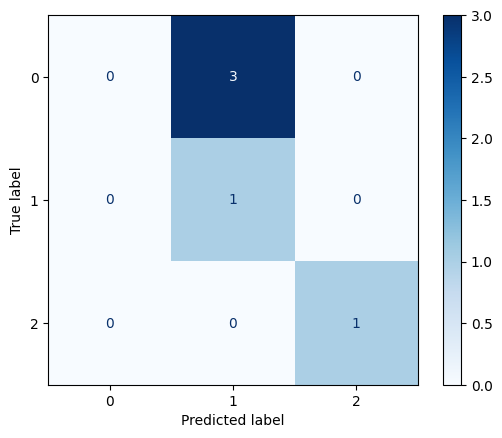

In [14]:
#plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [15]:
#Random Forest

#Tuning parameters using RandomSearch.
rf = RandomForestClassifier(random_state=42)

param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=20,
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200, 300]},
                   random_state=42, verbose=1)

In [16]:
best_params = random_search.best_params_
best_params

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'bootstrap': True}

In [17]:
#training with best parameters found
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [18]:
# Predicting...
y_pred = best_rf.predict(X_test)
accuracy_score(y_test, y_pred)

1.0

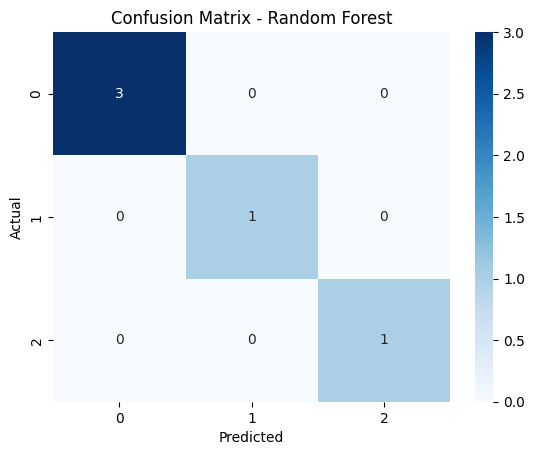

In [20]:
# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred)

sns.heatmap(cm_rf, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [21]:
#Training XgBoost
from xgboost import XGBClassifier

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [07:37:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [22]:
#Predicting
y_pred_xgb = xgb_model.predict(X_test)
accuracy_score(y_test, y_pred_xgb)

1.0

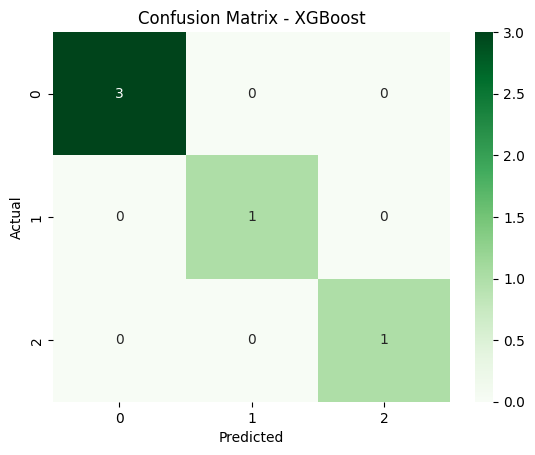

In [23]:
# Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)

sns.heatmap(cm_xgb, annot=True, fmt='d', cmap="Greens")
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()